## Supplement 4: Classification

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold

### 4.2 Programming Task: K-Nearest Neighbor
The datasets in files __train-knn.csv__ and __test-knn.csv__ contain samples from a synthetic dataset for training a K-Nearest Neighbor classifier.
The dataset consists of 7 columns: the first six columns, denoted as x1, x2, ..., x6 represent
 the input features for each data sample, and the last column represents the class label given by 0 or 1.
There are 200 samples in the __train-knn.csv__ and 100 samples in the __test-knn.csv__}.

i\. Implement the K-Nearest Neighbor classification algorithm using NumPy and SciPy.



In [4]:
train_set = pd.read_csv('train-knn.csv').to_numpy()
test_set = pd.read_csv('test-knn.csv').to_numpy()

def knn_predict(train_X, train_y, test_X, k):
    distance_matrix = cdist(train_X, test_X,)
    neighbour_indices = distance_matrix.argsort(axis=0)[:k]
    neighbour_class = train_y[neighbour_indices]
    frequent_class, _ = mode(neighbour_class, axis=0)
    return frequent_class.reshape(-1,)

def get_accuracy(predict_labels, true_labels):
    correct_count = np.sum([predict_labels == true_labels])
    total_samples = predict_labels.shape[0]
    accuracy = correct_count / total_samples
    return accuracy

# last coloumn is class label
train_X = train_set[:,:-1]
train_y = train_set[:,-1]

test_X = test_set[:,:-1]
test_y = test_set[:,-1]

# Using a subset of the original dataset
predicted_y = knn_predict(train_X[:16], train_y[:16], test_X[:4], k=3)

/tmp/ipykernel_3769/2793257483.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  frequent_class, _ = mode(neighbour_class, axis=0)


ii\. Perform cross-validation (with 5 folds) on the train dataset __train-knn.csv__ to determine a suitable value of K.


/tmp/ipykernel_3769/2793257483.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  frequent_class, _ = mode(neighbour_class, axis=0)


Best k:  6


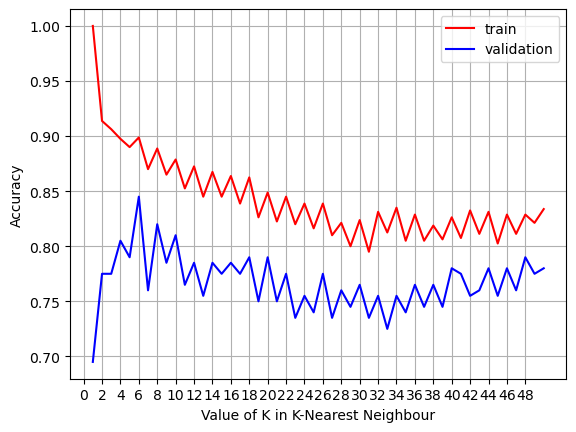

best k from cross validation: 6


,k,train_acc,val_acc
5,6.0,0.89875,0.845
7,8.0,0.88875,0.820
9,10.0,0.87875,0.810
3,4.0,0.89750,0.805
19,20.0,0.84875,0.790


In [8]:
n_fold = 5
train_size = train_set.shape[0]
indices = np.arange(train_size)
np.random.shuffle(indices)
splits = np.array_split(indices, n_fold)
# List to store metrics for each value of k
k_max = 50
exp = np.zeros((k_max, 3))
for k in range(1,k_max+1):
    val_acc = np.zeros(n_fold)
    train_acc = np.zeros(n_fold)
    for fold in range(n_fold):
        val_indices = splits[fold]
        # Create a mask that has 1 at val_set and 0 elsewhere
        mask = np.zeros(train_size, dtype=bool)
        mask[val_indices] = True
        cv_val_X = train_X[mask]
        cv_val_y = train_y[mask]
        cv_train_X = train_X[np.invert(mask)]
        cv_train_y = train_y[np.invert(mask)]
        # Train accuracy
        predicted_labels_train = knn_predict(cv_train_X, cv_train_y, cv_train_X, k)
        train_acc[fold] = get_accuracy(predicted_labels_train, cv_train_y)
        # Validation accuracy
        predicted_labels_val = knn_predict(cv_train_X, cv_train_y, cv_val_X, k)
        val_acc[fold] = get_accuracy(predicted_labels_val, cv_val_y)
    exp[k-1] = [k, train_acc.mean(), val_acc.mean()]
exp = pd.DataFrame(exp, columns=['k', 'train_acc', 'val_acc'])

plt.plot(exp['k'], exp['train_acc'], 'r', label='train')
plt.plot(exp['k'], exp['val_acc'], 'b', label='validation')
plt.grid()
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Value of K in K-Nearest Neighbour')
plt.xticks(np.arange(0,k_max,step=2))
plt.show()

exp.sort_values(by=['val_acc'], ascending=False, inplace=True)
best_k = int(exp.iloc[0]['k'])
print('best k from cross validation:', best_k)
exp.head()

iii\. Using the optimal value of k from the cross-validation, obtain the accuracy of your model on the test dataset __test-knn.csv__.


In [9]:
predicted_labels = knn_predict(train_X, train_y, test_X, best_k)
acc = get_accuracy(predicted_labels, test_y)
print(acc)

0.81


/tmp/ipykernel_3769/2793257483.py:8: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  frequent_class, _ = mode(neighbour_class, axis=0)


iv\. Compare your result with the KNeighborsClassifier model from the scikit-learn library.

In [19]:
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(train_X, train_y)
print('Accuracy using sklearn:', model.score(test_X, test_y))

knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 50)}
# Use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=KFold(5,shuffle=True))
knn_gscv.fit(train_X, train_y)
print('Best k using sklearn GridSearchCV:', knn_gscv.best_params_['n_neighbors'])

Accuracy using sklearn: 0.81
Best k using sklearn GridSearchCV: 10


v\. How do the bias and variance of each model vary as K increases?

- Variance decreases as decision bounds get smoother
- Bias decreases